# Proyecto del segundo parcial: Datos Karen App
Por: Fernando Gómez Perera y Vanessa Martínez Romero

El objetivo del presente proyecto es explorar distintas técnicas de aprendizaje supervisado sobre los datos generados por la app Karen App.

In [1]:
# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale

# CV and metrics
from sklearn.model_selection import train_test_split, GridSearchCV

### Models ###
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# SVM
from sklearn.svm import SVC
# Neural Network
from sklearn.neural_network import MLPClassifier

# Tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Data Frame
karen = pd.read_csv("DatosKarenApp.csv", usecols=range(1, 11))

## Exploración

Primero es necesario analizar el dataset con detalle, explorando el conjunto y cada variable de forma individual.

El dataset contiene 10 variables (representadas como columnas): 6 de ellas son numéricas (5 de tipo flotante y 1 de tipo entero) 3 de ellas son de tipo cadena (representadas como `object`) y una de ellas es de tipo booleano. Cada una de estas variables contiene 1192 valores no nulos, con índices que van del 0 al 1191.

In [2]:
karen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 10 columns):
Alert     1192 non-null bool
IQR       1192 non-null float64
Kurto     1192 non-null float64
Entro     1192 non-null float64
Skewn     1192 non-null float64
Sex       1192 non-null object
Comp      1192 non-null object
Picos     1192 non-null int64
Umbral    1192 non-null float64
Gama      1192 non-null object
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 85.1+ KB


Para la aplicación de los algoritmos de aprendizaje supervisado se tomará como variable de respuesta la variable *Alert*, y el resto de las variables se tomarán como variables predictoras. Esto significa que el dataset proporciona 6 variables predictoras numéricas y 3 variables predictoras categóricas.

La variable de respuesta *Alert* contiene solamente 2 clases: `True` y `False`. Éstas son las clases que trataremos de predecir, teniendo por lo tanto un problema de **clasificación**.

In [3]:
set(karen[['Alert']].values.reshape(-1))

{False, True}

Una pequeña muestra del contenido del dataset se visualiza a continuación.

In [4]:
karen.head()

,Alert,IQR,Kurto,Entro,Skewn,Sex,Comp,Picos,Umbral,Gama
0,False,2.6938,1.73447,1.76160,0.140613,Mujer,Slim,0,15.708,Alta
1,False,2.5478,2.08198,1.71931,0.104144,Mujer,Slim,0,15.861,Alta
2,False,2.5754,3.82861,1.53336,0.687755,Mujer,Slim,2,17.283,Alta
3,False,2.5976,1.97106,1.74680,-0.076770,Mujer,Slim,1,17.490,Alta
4,False,2.5725,1.94219,1.73949,0.130674,Mujer,Slim,0,15.621,Alta


### Análisis de las variables predictoras numéricas

Algunos estadísticos descriptivos de las variables numéricas se visualizan en la siguiente tabla. 

Es claro que cada variable tiene escalas muy distintas, y medias muy distantes entre sí. Por ello, estas variables se estandarizarán para evitar que alguna de ellas influya de forma excesiva en el resultado de los algoritmos debido a su escala.

In [5]:
karen.describe()

,IQR,Kurto,Entro,Skewn,Picos,Umbral
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,3.344743,10.463423,1.429699,1.942713,2.255034,27.146123
std,3.811354,11.603588,0.501740,1.441459,2.630390,13.736920
min,0.021700,-1.409000,0.155600,-0.692600,0.000000,-14.976000
25%,0.644850,1.371075,1.006950,0.727318,1.000000,17.665225
50%,1.768673,6.452670,1.412100,1.553150,1.000000,22.288000
75%,4.053943,16.431000,1.885632,2.842425,3.000000,31.658800
max,18.507000,61.459600,2.253400,7.584200,18.000000,89.547700


Las gráficas de boxplot revelan la existencia de valores atípicos entre las variables numéricas.

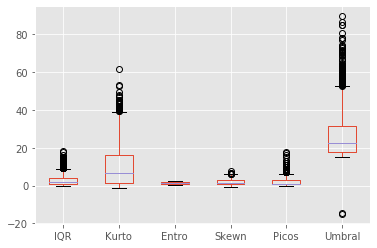

In [6]:
karen.iloc[:, 1:].boxplot()
plt.show()

La gráfica pairplot permite visualizar la dispersión de las variables numéricas entre sí, mostrando los puntos pertenecientes a cada clase con un color diferente. Además, en las intersecciones de las variables consigo mismas se muestran la distribuciones de sus valores de acuerdo a la clase a la que pertenecen.

Gracias a esta gráfica, es posible apreciar que las clases se traslapan en prácticamente todas las variables, y no resulta tan fácil dividirlas.

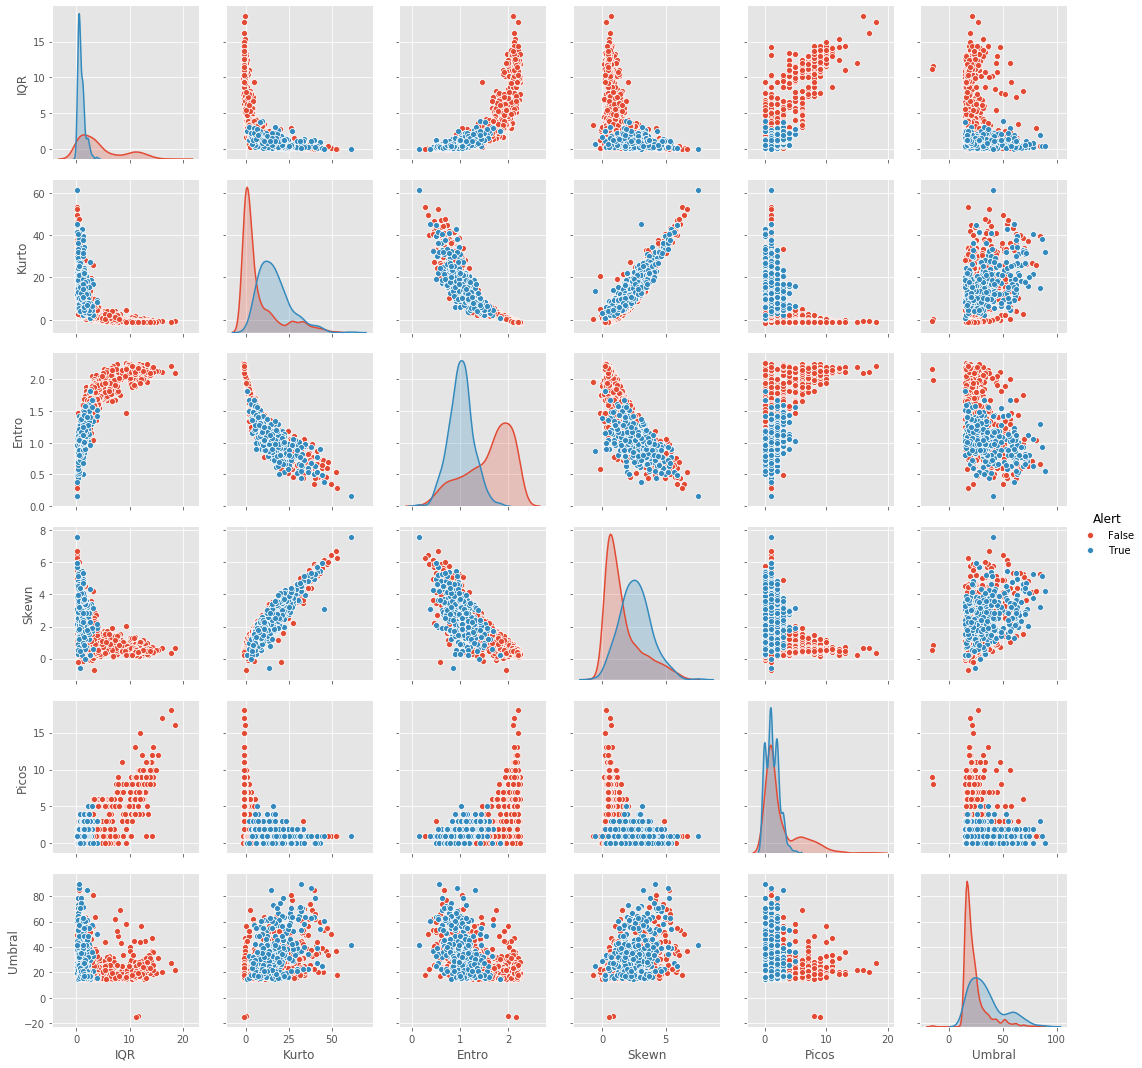

In [7]:
sns.pairplot(data=karen, hue='Alert', vars=karen.select_dtypes(include=np.number).columns)
plt.show()

Finalmente, usando un heatmap se visualiza la correlación entre las variables numéricas. Algunas de ellas tienen una correlación positiva alta, como las variables *Kurto* y *Skewn*, y otras tienen una correlación negativa muy alta, como *Entro* y *Kurto*.

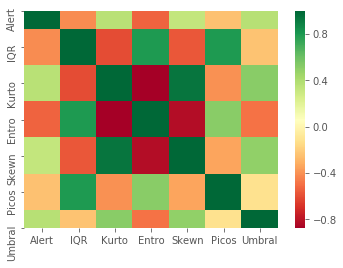

In [8]:
sns.heatmap(karen.corr(), square=True, cmap='RdYlGn')
plt.show()

### Análisis de las variables predictoras categóricas

La variable *Sex* contiene solamente 2 valores: `Mujer` y `Hombre`. La gráfica expone la existencia de una mayor cantidad de alertas `False` que de alertas `True`, tanto en hombres como en mujeres.

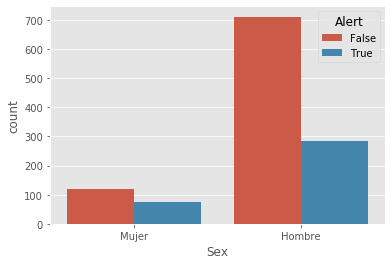

In [9]:
sns.countplot(x='Sex', hue='Alert', data=karen)
plt.show()

La variable *Comp* contiene 3 valores: `Slim`, `Medium`, `Robust`. Nuevamente, la clase `False` supera en todos los valores a la alerta `True`.

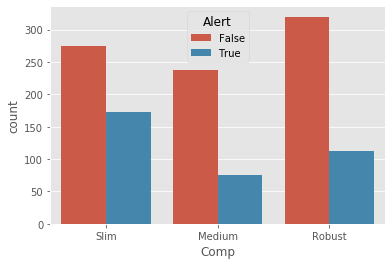

In [10]:
sns.countplot(x='Comp', hue='Alert', data=karen)
plt.show()

Finalmente, la variable *Gama* contiene 2 valores: `Alta` y `Media`. En este último caso, también la clase `False` supera en ambos casos a la clase `True`.

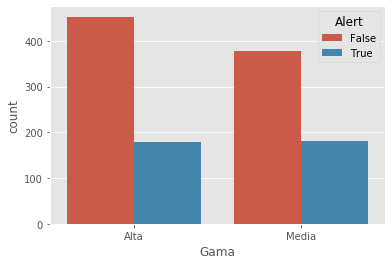

In [11]:
sns.countplot(x='Gama', hue='Alert', data=karen)
plt.show()

Para poder aplicar los modelos a estas variables, sus valores se codificarán usando *dummy variables*, convertiéndolas a variables numéricas para que puedan ser interpretadas por los algoritmos.

## Preproceso de los datos

Como ya se mencionó, el dataset sufrirá 2 tipos de transformaciones, de acuerdo al tipo de variable.

* Las variables predictoras numéricas se estandarizarán para evitar influencias en sus escalas.
* Las variables predictoras categóricas se codificarán usando *dummy variables* para convertirlas a variables numéricas.

### Estandarización de las variables predictoras numéricas

El escalamiento se llevará a cabo dentro de un `pipeline` al momento de aplicar el modelo. Sin embargo, los datos escalados se verán de la siguiente forma.

In [12]:
pd.DataFrame(scale(karen.select_dtypes(include=np.number))).describe()

,0,1,2,3,4,5
count,1.192000e+03,1.192000e+03,1.192000e+03,1.192000e+03,1.192000e+03,1.192000e+03
mean,1.788279e-17,-4.470697e-17,1.311404e-16,-5.364836e-17,1.192186e-17,-2.384372e-16
std,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00
min,-8.722459e-01,-1.023598e+00,-2.540429e+00,-1.828993e+00,-8.576600e-01,-3.067631e+00
25%,-7.086789e-01,-7.839096e-01,-8.429202e-01,-8.435243e-01,-4.773286e-01,-6.904661e-01
50%,-4.136933e-01,-3.457927e-01,-3.509063e-02,-2.703696e-01,-4.773286e-01,-3.538029e-01
75%,1.861535e-01,5.145031e-01,9.090869e-01,6.244292e-01,2.833341e-01,3.286451e-01
max,3.979851e+00,4.396707e+00,1.642379e+00,3.915375e+00,5.988305e+00,4.544524e+00


Con esto se logra que todas las variables predictoras numéricas tengan una media de 0, y una desviación estándar de 1.

### Codificación de las variables predictoras categóricas

Las variables categóricas se codificarán usando *dummy variables*. Esta técnica permite binarizar los valores de estas variables convirtiéndolas en variables numéricas.

Para ello, las columnas de estas variables se pivotan creando $n$ nuevas columnas, donde cada nueva columna corresponde a cada uno de los posibles valores dentro de la variable categórica. Cada columna tendrá en cada observación un número $1$ si la observación cumple con ese valor, y un número $0$ si la observación no cumple con ese valor.

Además, para evitar repetición en la información, indicamos que una de las columnas de cada variable categórica se omitirá, quedándonos con $n-1$ nuevas columnas por cada variable categórica.

In [13]:
karen = pd.get_dummies(karen, drop_first=True)
karen

,Alert,IQR,Kurto,Entro,Skewn,Picos,Umbral,Sex_Mujer,Comp_Robust,Comp_Slim,Gama_Media
0,False,2.6938,1.73447,1.76160,0.140613,0,15.7080,1,0,1,0
1,False,2.5478,2.08198,1.71931,0.104144,0,15.8610,1,0,1,0
2,False,2.5754,3.82861,1.53336,0.687755,2,17.2830,1,0,1,0
3,False,2.5976,1.97106,1.74680,-0.076770,1,17.4900,1,0,1,0
4,False,2.5725,1.94219,1.73949,0.130674,0,15.6210,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1187,False,1.3148,10.20850,1.29870,2.259400,1,23.3948,0,1,0,1
1188,False,1.8617,12.21340,1.34510,2.746900,2,25.0273,0,1,0,1
1189,False,1.6347,10.07640,1.34480,2.259100,2,24.0312,0,1,0,1
1190,False,0.5446,31.33600,0.77840,4.463900,2,17.6337,0,1,0,0


### Creación de los conjuntos de entrenamiento y prueba

Resulta necesario crear los conjuntos de entrenamiento y prueba a partir del dataset para poder usarlos en la implementación de los modelos.

Para ello, primero se separan los valores de las variables predictoras de los valores de la variable de respuesta.

In [14]:
# Valores de las variables predictoras
X = karen.drop('Alert', axis=1).values
X

array([[ 2.6938 ,  1.73447,  1.7616 , ...,  0.     ,  1.     ,  0.     ],
       [ 2.5478 ,  2.08198,  1.71931, ...,  0.     ,  1.     ,  0.     ],
       [ 2.5754 ,  3.82861,  1.53336, ...,  0.     ,  1.     ,  0.     ],
       ...,
       [ 1.6347 , 10.0764 ,  1.3448 , ...,  1.     ,  0.     ,  1.     ],
       [ 0.5446 , 31.336  ,  0.7784 , ...,  1.     ,  0.     ,  0.     ],
       [ 0.8021 , 26.1422 ,  0.832  , ...,  1.     ,  0.     ,  0.     ]])

In [15]:
# Valores de la variable de respuesta
y = karen[['Alert']].values
y = np.reshape(y, -1)
y

array([False, False, False, ..., False, False, False])

Finalmente se crean los conjuntos de entrenamiento y prueba a partir de los datos separados. Como las instrucciones dle proyecto indican, se separa el 25% de las observaciones para el conjunto de prueba, y se define un `random_state` igual a 100.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100, stratify=y)

## Implementación

Cada modelo se implementará por medio de un `pipeline`. Un `pipeline` permite agrupar un conjunto de pasos a seguir antes de comenzar a usar un modelo. En cada caso, el conjunto de pasos a seguir estará conformado por la estandarización de las variables numéricas antes de la definición del modelo en cuestión.

Usando *k-fold cross validation* se podrán ajustar los parámetros de cada modelo. De esta forma, será posible encontrar el mejor clasificador para cada uno de ellos. Para lograrlo, se usará la función `GridSearchCV`, la cual permite aplicar *k-fold cross validation* de forma automatizada a partir del número de *folds* o *dobleces* que se definan, que en cada caso será de 10.

Además, cada modelo usará como métrica el *F1 Score*. Esta métrica permite calcular la media harmónica entre otras dos métricas: La métrica de *Exhaustividad* o *Recall*, que calcula el porcentaje de resultados clasificados como `True`, junto con la métrica de *Precisión* o *Precision*, que calcula el porcentaje de resultados clasificados como `True` **de forma correcta**. La fórmula del *F1 Score* tiene la siguiente forma:

$F1score=2\ast\frac{Precision \ast Recall}{Precision+Recall}$

Esta medida adquire valores altos (más cercanos a 1) cuando los valores de *Precision* y *Recall* son altos, y se encuentran en balance (son cercanos entre sí).

### K-Nearest Neighbors

Este modelo tiene como parámetro el número de vecinos `n_neighbors`. Un valor bajo de `n_neighbors` puede generar un modelo con *overfit*, mientras que un valor alto de `n_neighbors` puede generar un modelo con *underfit*. Por ello, usando *k-fold cross validation* se logrará encontrar el número de vecinos que genere el mejor clasificador.

In [17]:
# Creacion del pipeline
steps = [('scaler', StandardScaler()),
         ('KNN', KNeighborsClassifier())]

pipeline = Pipeline(steps)

# El parametro por ajustar en el modelo es el numero de vecinos
# Para ello, se probaran valores de n_neighbors entre 1 y 10
params = {'KNN__n_neighbors': range(1, 10)}

# Finalmente, se crea el clasificador
knn_cv = GridSearchCV(pipeline, params, scoring='f1', iid=False, cv=10)

Al entrenar el clasificador, la función `GridSearchCV` se encargará de probar los valores definidos para `n_neighbors`, y decidirá de forma automática cuál de ellos genera el mejor clasificador.

In [18]:
# Entrenamiento del modelo
knn_cv.fit(X_train, y_train)

# Numero de vecinos que genera el mejor clasificador
knn_cv.best_params_

{'KNN__n_neighbors': 1}

### Logistic Regression

Este modelo tiene como parámetro el valor de regularización `C`, también llamado *parámetro de regularización inversa*, el cual controla la inversa de la intensidad de regularización. Un valor alto de `C` puede generar un modelo con *overfit*, mientras que un valor bajo de `C` puede generar un modelo con *underfit*. Por ello, usando *k-fold cross validation* se logrará encontrar el valor de `C` que genere el mejor clasificador.

In [19]:
# Creacion del pipeline
steps = [('scaler', StandardScaler()),
         ('LogReg', LogisticRegression(solver='liblinear'))]

pipeline = Pipeline(steps)

# El parametro por ajustar en el modelo es el valor flotante de C
# Para ello, se probaran 15 valores de C en una escala logaritmica entre -1 y 8
params = {'LogReg__C': np.logspace(-5, 8, 15)}

# Finalmente, se crea el clasificador
logreg_cv = GridSearchCV(pipeline, params, scoring='f1', iid=False, cv=10)

Al entrenar el clasificador, la función `GridSearchCV` se encargará de probar los valores definidos para `C`, y decidirá de forma automática cuál de ellos genera el mejor clasificador.

In [20]:
# Entrenamiento del modelo
logreg_cv.fit(X_train, y_train)

# Valor de C que genera el mejor clasificador
logreg_cv.best_params_

{'LogReg__C': 0.4393970560760795}

### Support Vector Machine (SVM)

Este modelo tiene como parámetro el tipo de `kernel` a usar. Un `kernel` es una función que se aplica sobre los valores de entrada para transformarlos. Usando *k-fold cross validation* se encontrará el `kernel` que genere el mejor clasificador.

In [21]:
# Creacion del pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

# El parametro por ajustar en el modelo es el tipo de kernel
# Para ello, se probaran distintos tipos de kernel
params = {'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# Finalmente, se crea el clasificador
svm_cv = GridSearchCV(pipeline, params, scoring='f1', iid=False, cv=10)

Al entrenar el clasificador, la función `GridSearchCV` se encargará de probar los distintos tipos de `kernel` definidos, y decidirá de forma automática cuál de ellos genera el mejor clasificador.

In [22]:
# Entrenamiento del modelo
svm_cv.fit(X_train, y_train)

# Kernel que genera el mejor clasificador
svm_cv.best_params_

{'SVM__kernel': 'rbf'}

### Neural Network

Este modelo tiene como parámetro la estructura de la red. Esto incluye el número de capas, y la cantidad de perceptrones por capa.

In [23]:
# Creacion del pipeline
steps = [('scaler', StandardScaler()),
         ('MLP', MLPClassifier(activation='logistic', max_iter=500, tol=0.001))]

pipeline = Pipeline(steps)

# Creacion de las capas con diferente numero de neuronas
mlp_struct = list()
max_neurons = 5

# Una capa
for i in range(1, max_neurons + 1):
    mlp_struct.append((i,))
    
# Dos capas
for i in range(1, max_neurons + 1):
    for j in range(1, max_neurons + 1):
        mlp_struct.append((i, j))
        
# Tres capas
for i in range(1, max_neurons + 1):
    for j in range(1, max_neurons + 1):
        for k in range(1, max_neurons + 1):
            mlp_struct.append((i, j, k))
            
# Cuatro capas
for i in range(1, max_neurons + 1):
    for j in range(1, max_neurons + 1):
        for k in range(1, max_neurons + 1):
            for l in range(1, max_neurons + 1):
                mlp_struct.append((i, j, k, l))
                
# Cinco capas
for i in range(1, max_neurons + 1):
    for j in range(1, max_neurons + 1):
        for k in range(1, max_neurons + 1):
            for l in range(1, max_neurons + 1):
                for m in range(1, max_neurons + 1):
                    mlp_struct.append((i, j, k, l, m))

# El parametro por ajustar en el modelo es el tipo de kernel
# Para ello, se probaran distintos tipos de kernel
params = {'MLP__hidden_layer_sizes': mlp_struct}

# Finalmente, se crea el clasificador
mlp_cv = GridSearchCV(pipeline, params, scoring='f1', iid=False, n_jobs=10, cv=10)

In [24]:
# Entrenamiento del modelo
mlp_cv.fit(X_train, y_train)

# Estructura de la red que genera el mejor clasificador
mlp_cv.best_params_

{'MLP__hidden_layer_sizes': (4,)}

## Evaluación del modelo

Finalmente, se evalúa la calidad de los clasificadores usando el conjunto de prueba para predecir las clases. Para ello, se toma nuevamente la métrica *F1 score*, la cual ya está configurada en cada modelo, y se visualiza el resultado de la métrica para cada modelo en cuestión.

El conjunto de prueba contiene 298 valores, donde el mejor clasificador parece ser el modelo *Support Vector Machine* al tener menos errores de predicción.

In [25]:
res = {"Real": y_test,
       "KNN": knn_cv.predict(X_test),
       "LogReg": logreg_cv.predict(X_test),
       "SVM": svm_cv.predict(X_test),
       "MLP": mlp_cv.predict(X_test)}

df_res = pd.DataFrame(res)

print("\nTamaño del conjunto de prueba: ", len(df_res))
print("Predicciones erróneas (KNN): ", len(df_res[df_res["Real"] != df_res["KNN"]]))
print("Predicciones erróneas (LogReg): ", len(df_res[df_res["Real"] != df_res["LogReg"]]))
print("Predicciones erróneas (SVM): ", len(df_res[df_res["Real"] != df_res["SVM"]]))
print("Predicciones erróneas (MLP): ", len(df_res[df_res["Real"] != df_res["MLP"]]), "\n")

df_res.head()


Tamaño del conjunto de prueba:  298
Predicciones erróneas (KNN):  50
Predicciones erróneas (LogReg):  58
Predicciones erróneas (SVM):  47
Predicciones erróneas (MLP):  84 



,Real,KNN,LogReg,SVM,MLP
0,False,False,False,False,False
1,False,True,False,False,False
2,False,False,False,False,False
3,True,False,False,False,False
4,False,False,True,True,False


Como ya se mencionó, al usar la métrica *F1 score* estamos comprometiendo los valores de *Recall* y *Precision* para que sean altos y se encuentren en balance.

Finalmente,

In [26]:
metrics = {"Model": ["KNN", "LogReg", "SVM", "MLP"],
           "F1 Score": [knn_cv.score(X_test, y_test),
                        logreg_cv.score(X_test, y_test),
                        svm_cv.score(X_test, y_test),
                        mlp_cv.score(X_test, y_test)]}

pd.DataFrame(metrics, index=None)

,Model,F1 Score
0,KNN,0.719101
1,LogReg,0.666667
2,SVM,0.728324
3,MLP,0.424658


Finalmente, los resultados arrojan que el SVM es el mejor clasificador para estos datos.